Loading to TensorFlow computation graphs saved in the CostGraphDef format (https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/proto/framework/CostGraphDef) open-sourced in the DeepMind REGAL paper (https://openreview.net/attachment?id=rkxDoJBYPB&name=original_pdf)

Each node has:
- `input_info` -> Data dependency edges. `preceding_node` gives parent node of edge. `preceeding_port` can be ignored since always set to 1.
- `output_info` -> Data dependency edges. `size` gives size (in Bytes) of data to be sent to child, `alias_input_port` can be ignored since always set to -1.
- `control_input` -> Control dependency edges. Value gives parent node of edge. Can have multiple entries per node.
- `compute_cost` -> Gives estimated time (in ms) to run the operation.

In [1]:
import glob

# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
print(f'Number of files: {len(file_paths)}\nFile paths:')
for path in file_paths:
    print(path)

Number of files: 1000
File paths:
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_1511656116089178154.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2261927831951531680.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5215600956903632739.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6504598570401295612.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-4070510387734494791.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6604561797351554465.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_2061414314887524887.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2024792864167345906.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5154055352329412961.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_8486481254233036434.pbtxt
/scratch/datasets/ddl

In [2]:
from collections import defaultdict
import copy
import time
import json

# load a tensorflow computation graph from a .pbtxt file
def pbtxt_nodes_from_pbtxt_file(file_path, verbose=False):
    graph, start_time = [], time.time_ns()
    with open(file_path, 'r') as file:
        node_info = None
        for line in file:
            line = line.replace(' ', '').replace('\n', '')
            if line == 'node{':
                # new node entry, save previous node's info and reset
                if node_info is not None:
                    graph.append(copy.deepcopy(node_info))
                node_info = defaultdict(list)  
            elif line == '}':
                # ended previouse element entry
                pass
            elif 'id' in line:
                node_info['id'] = int(line.split(":", 1)[1].strip())
            elif 'name' in line:
                if '_SOURCE' in line:
                    node_info['id'] = 0
            elif 'input_info' in line:
                pass
            elif 'preceding_node' in line:
                node_info['input_info'].append(int(line.split(":", 1)[1].strip()))
            elif 'preceding_port' in line:
                pass
            elif 'output_info' in line:
                pass
            elif 'size' in line:
                node_info['output_info'].append(int(line.split(":", 1)[1].strip()))
            elif 'alias_input_port' in line:
                pass
            elif 'control_input' in line:
                node_info['control_input'].append(int(line.split(":", 1)[1].strip()))
            elif 'compute_cost' in line:
                node_info['compute_cost'] = int(line.split(":", 1)[1].strip())
            else:
                raise Exception(f'Unrecognised line {line}')
    if verbose:
        print(f'Parsed file {file_path} in {(time.time_ns() - start_time)*1e-9:.3f} s')
                
    return graph

file_path = file_paths[0]
pbtxt_nodes = pbtxt_nodes_from_pbtxt_file(file_path, verbose=True)
print(f'Num nodes: {len(pbtxt_nodes)}')
print(json.dumps(pbtxt_nodes, sort_keys=True, indent=2))

Parsed file /scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_1511656116089178154.pbtxt in 0.003 s
Num nodes: 96
[
  {
    "id": 0
  },
  {
    "compute_cost": 65,
    "control_input": [
      0
    ],
    "id": 1,
    "output_info": [
      63
    ]
  },
  {
    "compute_cost": 61,
    "control_input": [
      0
    ],
    "id": 2,
    "output_info": [
      73
    ]
  },
  {
    "compute_cost": 124,
    "id": 3,
    "input_info": [
      2
    ],
    "output_info": [
      54
    ]
  },
  {
    "compute_cost": 51,
    "control_input": [
      0
    ],
    "id": 4,
    "output_info": [
      54
    ]
  },
  {
    "compute_cost": 39,
    "control_input": [
      0
    ],
    "id": 5,
    "output_info": [
      41
    ]
  },
  {
    "compute_cost": 123,
    "id": 6,
    "input_info": [
      3
    ],
    "output_info": [
      49
    ]
  },
  {
    "compute_cost": 243,
    "id": 7,
    "input_info": [
      2,
      3,
      4
    ],
    "output_info": [
      63
    ]

**Side note on below 'hack'**: The .pbtxt open-sourced by DeepMind do not say which child each data dependency is connected to, therefore if have e.g. 1 parent node connected to 2 child nodes via 2 data dependencies, then cannot know which data dependency is applied to which child node. Therefore, in below implementation, if there are multiple possible data dependency sizes, we simply randomly sample a size for the dependency from amongst the possible sizes so that we retain the original distribution of sizes open-sourced by DeepMind.

In [3]:
import networkx as nx
import random

# construct a networkx graph from loaded nodes
def pbtxt_graph_from_pbtxt_nodes(nodes, verbose=False):
    graph = nx.MultiDiGraph()
    
    for node in nodes:
        # add operation
        graph.add_node(node['id'], compute_time=0, output_info=[])
        for attr in node:
            graph.nodes[node['id']][attr] = node[attr]
        
        # add preceding data dependencies
        for parent in node['input_info']:
            # hack: randomly sampling a size if have multiple possibilities (see above markdown cell)
            graph.add_edge(parent, node['id'], size=random.choice(graph.nodes[parent]['output_info']))
                           
        # add preceding control dependencies
        for parent in node['control_input']:
            graph.add_edge(parent, node['id'], size=0)
            
    if verbose:
        print(f'Num nodes: {len(graph.nodes)}')
        print(f'Num edges: {len(graph.edges)}')
        
    return graph

pbtxt_computation_graph = pbtxt_graph_from_pbtxt_nodes(pbtxt_nodes)

Lets convert the features of the nodes and edges in our `pbtxt` graph into some features which are more useful for ML and interpreting each edge and node on an individual basis rather than having complicated look-up systems. We will refer to this more useful graph as a `ddls` graph.

In [4]:
def ddls_graph_from_pbtxt_graph(pbtxt_graph, verbose=False):
    '''
    Returns a directed multi-graph (i.e. can have multiple edges between
    a given parent and child node). Since is a multi-graph, each edge is
    a 3-tuple (u, v, k) where u is the parent node, v is the child node,
    and k is the index of the multi-edge used to distringuish between
    the multi-edges of a pair of nodes.
    
    Each node has the following attributes:
        compute_cost: Operation compute time (ms)
        memory_cost: Operation memory size (B)
        
    Each edge has the following features:
        size: Size of tensor being transferred by dependency (B)
    '''
    ddls_graph = nx.MultiDiGraph()
    
    if verbose:
        print('\n\n~~~ Adding Nodes ~~~')
    for node in pbtxt_graph.nodes:
        node_attrs = pbtxt_graph.nodes[node]
        if verbose:
            print(f'\npbtxt node {node} attrs:')
            print(node_attrs)
        
        ddls_graph.add_node(node,
                            compute_cost=node_attrs['compute_cost'] if 'compute_cost' in node_attrs else 0,
                            memory_cost=node_attrs['memory_cost'] if 'memory_cost' in node_attrs else 0)
            
        if verbose:
            print(f'ddls node {node} attrs:')
            print(ddls_graph.nodes[node])
            
    if verbose:
        print('\n\n~~~ Adding Edges ~~~')
    for edge in pbtxt_graph.edges:
        edge_attrs = pbtxt_graph[edge[0]][edge[1]][edge[2]]
        if verbose:
            print(f'\npbtxt edge {edge} attrs:')
            print(edge_attrs)
            
        ddls_graph.add_edge(u_for_edge=edge[0],
                            v_for_edge=edge[1],
                            key=edge[2],
                            size=edge_attrs['size'] if 'size' in edge_attrs else 0)
        
        if verbose:
            print(f'ddls edge {edge} attrs:')
            print(ddls_graph[edge[0]][edge[1]][edge[2]])
            
    if verbose:
        print(f'Num nodes: {len(ddls_graph.nodes)}')
        print(f'Num edges: {len(ddls_graph.edges)}')
    
    return ddls_graph

ddls_computation_graph = ddls_graph_from_pbtxt_graph(pbtxt_computation_graph, verbose=False)

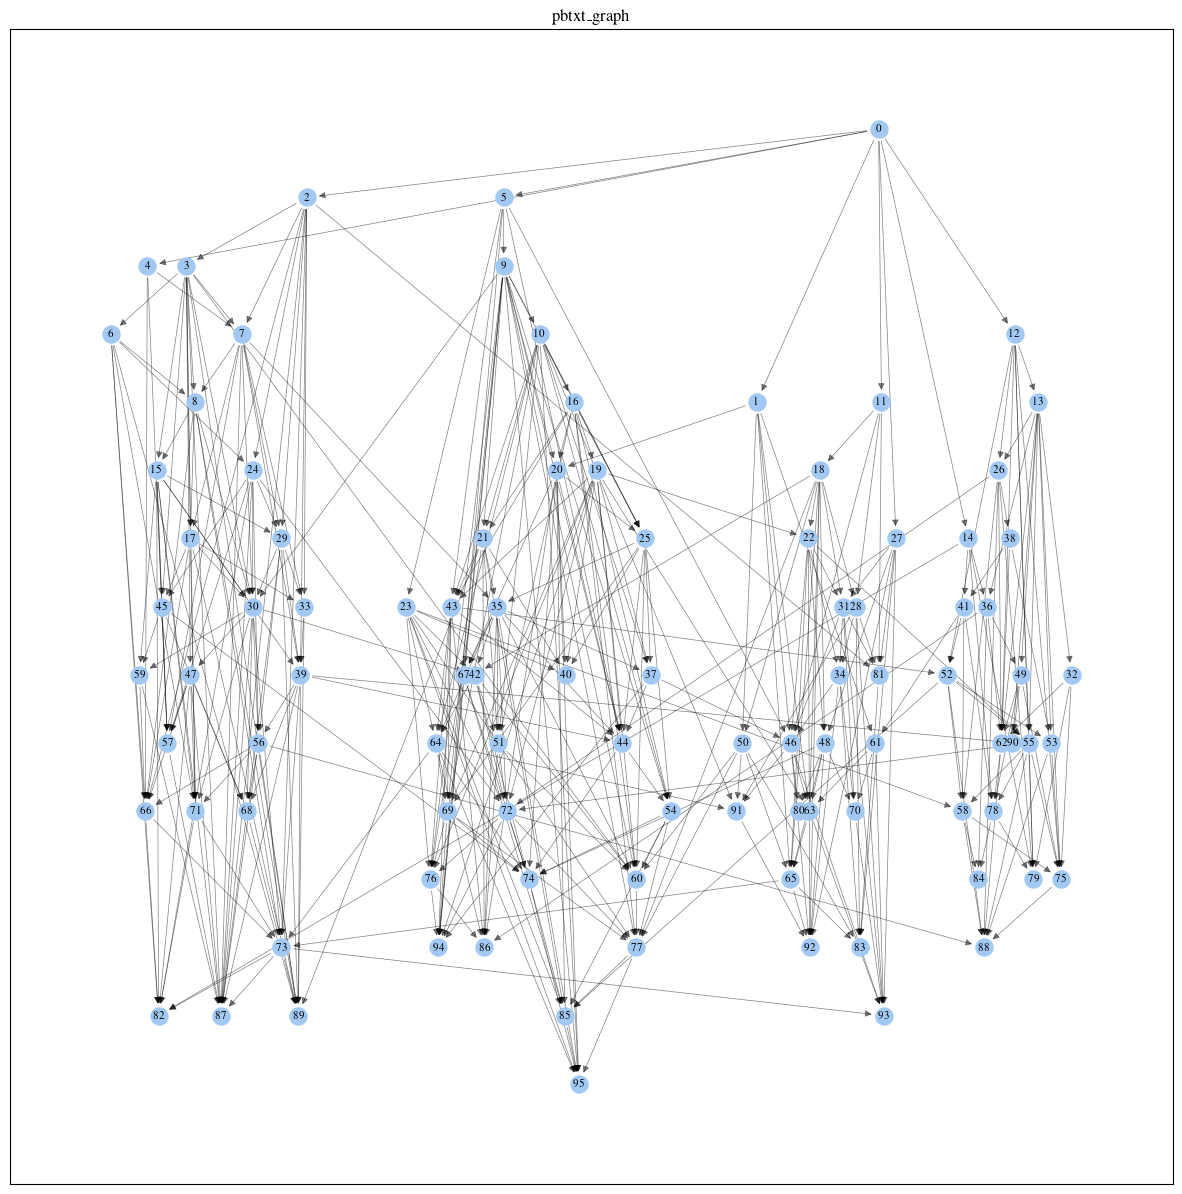

Constructed figure in 5.978 s


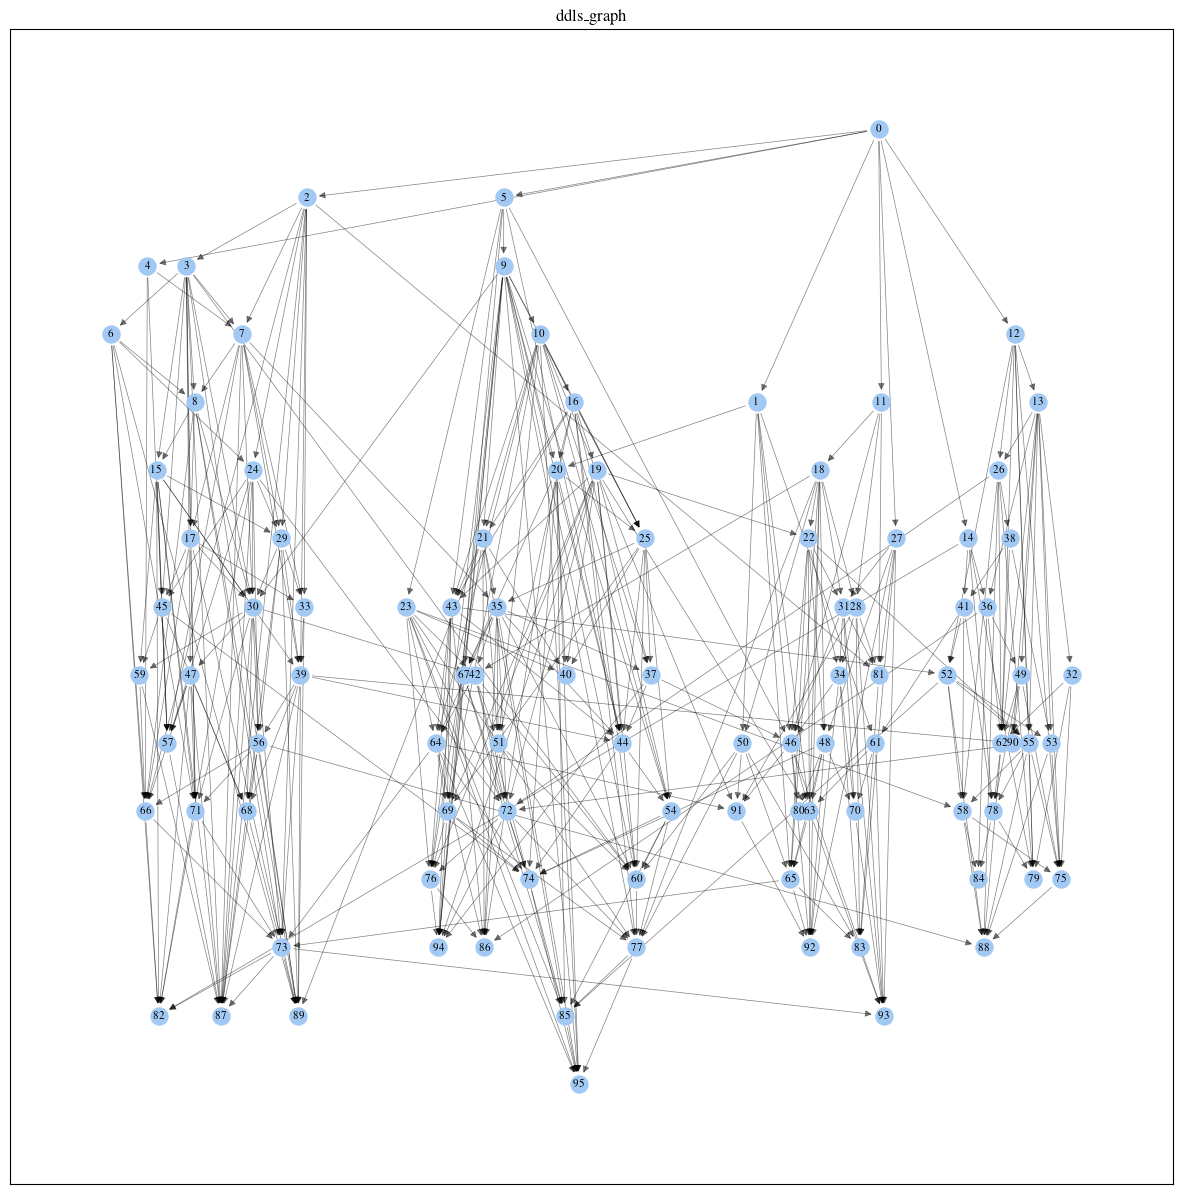

Constructed figure in 5.293 s


In [5]:
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import matplotlib.pyplot as plt

# use latex fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

# visualise computation graph
def render_computation_graph(graph,
                             figsize=(15, 15),
                             node_color_palette='pastel',
                             node_size=150,
                             edge_alpha=0.5,
                             edge_width=0.5,
                             font_size=8,
                             title=None,
                             verbose=False):
    start_time = time.time_ns()
    fig = plt.figure(figsize=figsize)
    
    pos = graphviz_layout(graph, prog='dot')
    
    node_labels = {node: node for node in graph.nodes}
    nx.draw_networkx_nodes(graph,
                           pos,
                           node_size=node_size,
                           node_color=sns.color_palette(node_color_palette)[0],
                           label=node_labels)
    
    nx.draw_networkx_edges(graph,
                           pos,
                           alpha=edge_alpha,
                           width=edge_width)
    
    nx.draw_networkx_labels(graph, 
                            pos, 
                            labels=node_labels,
                            font_size=font_size)
    
    if title is not None:
        plt.title(title)
    
    plt.show()
    
    if verbose:
        print(f'Constructed figure in {(time.time_ns() - start_time) * 1e-9:.3f} s')

render_computation_graph(pbtxt_computation_graph, title='pbtxt_graph', verbose=True)
render_computation_graph(ddls_computation_graph, title='ddls_graph', verbose=True)

# Integrating above into `ddls`

In [6]:
%load_ext autoreload
import ddls
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob

In [7]:
%autoreload

# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
print(f'Number of files: {len(file_paths)}\nFile paths:')
for path in file_paths:
    print(path)

Number of files: 1000
File paths:
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_1511656116089178154.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2261927831951531680.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5215600956903632739.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6504598570401295612.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-4070510387734494791.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_6604561797351554465.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_2061414314887524887.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-2024792864167345906.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_-5154055352329412961.pbtxt
/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid/graph_8486481254233036434.pbtxt
/scratch/datasets/ddl

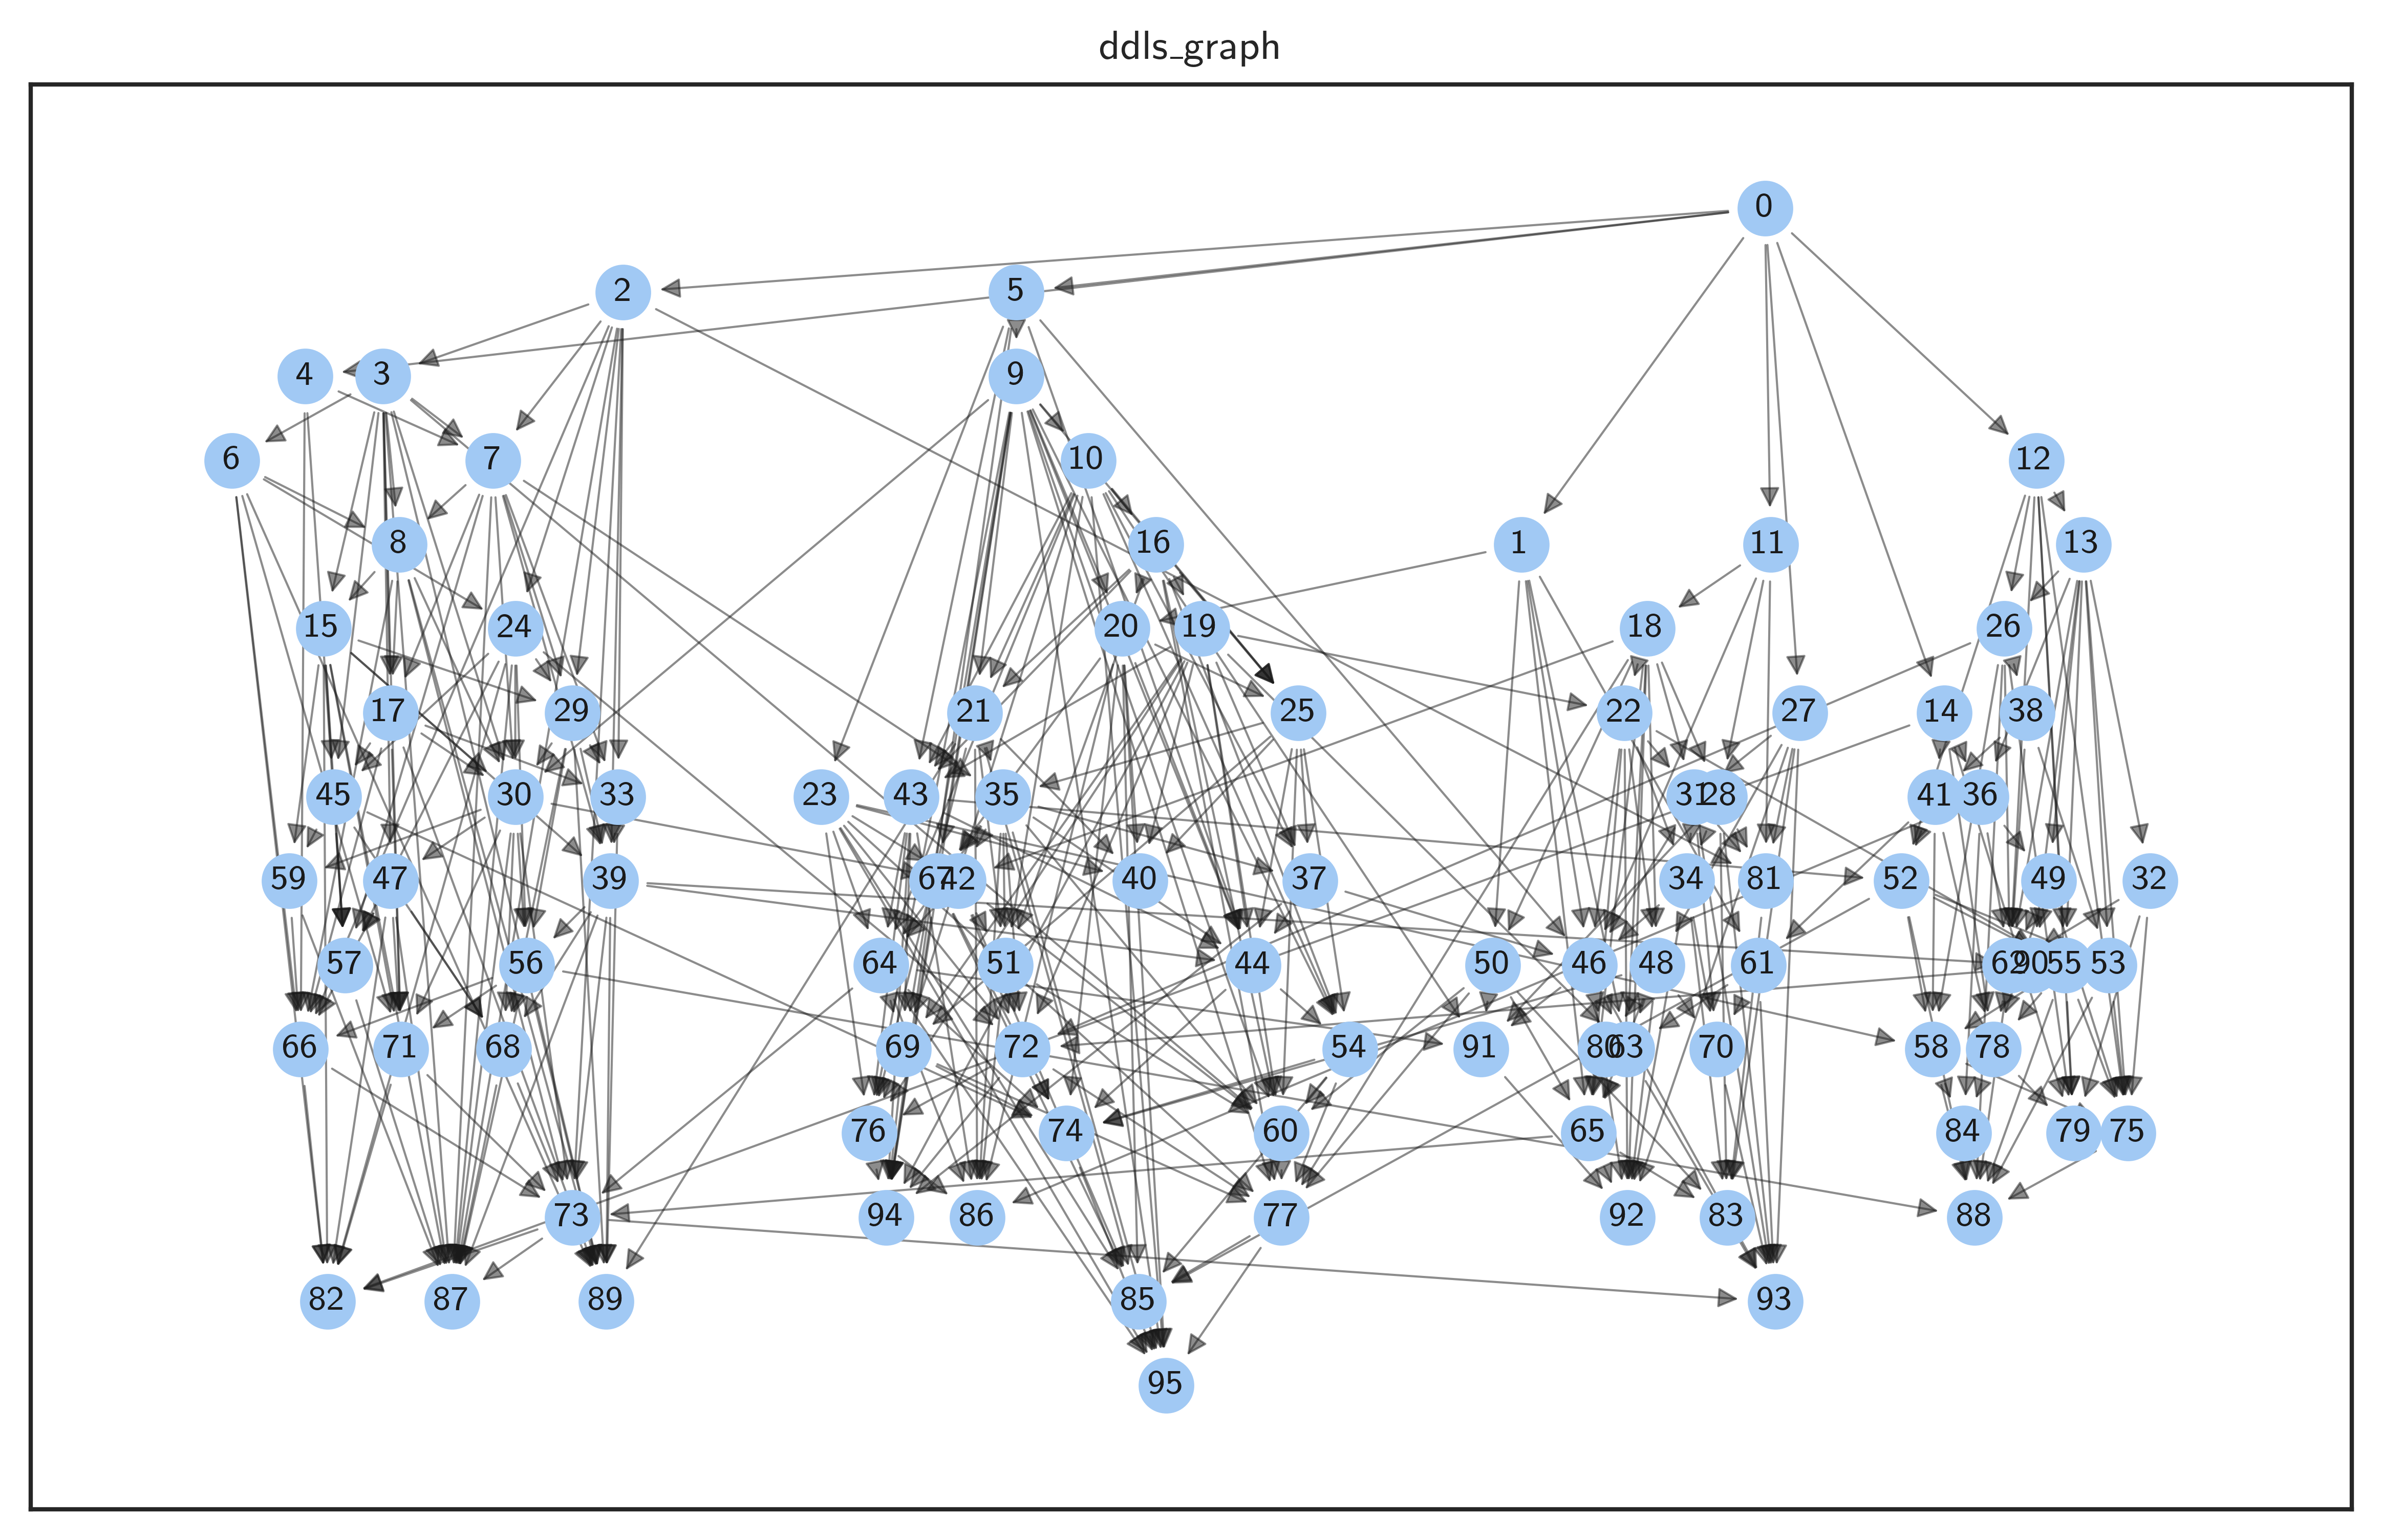

Constructed figure in 24.373 s


In [8]:
%autoreload

# create ddls graph
ddls_computation_graph = ddls_graph_from_pbtxt_file(file_paths[0], verbose=False)

# visualise
fig = plot_computation_graph(ddls_computation_graph, scaling_factor=3, title='ddls_graph', verbose=True)